## Outline of the data
In this post, we’ll be building a no frills RNN that accepts a binary sequence X and uses it to predict a binary sequence Y. The sequences are constructed as follows:

* **Input sequence** ($X$): At time step $t$, $X_t$ has a 50% chance of being 1 (and a 50% chance of being 0). E.g., $X$ might be $[1, 0, 0, 1, 1, 1 … ].$
* **Output sequence** ($Y$): At time step $t$, $Y_t$ has a base 50% chance of being 1 (and a 50% base chance to be 0). The chance of $Y_t$ being 1 is increased by 50% (i.e., to 100%) if $X_{t−3}$ is 1, and decreased by 25% (i.e., to 25%) if $X_{t-8}$ is 1. If both are 1, the chance of $Y_t$ being 1 is 50% + 50% - 25% = 75%.


In [2]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.6615632381579821
- learns first dependency:   0.5191666997072094
- learns both dependencies:  0.4544543674493905


## Model architecture

The model will be as simple as possible: at time step $t$, for $t∈{0,1,…n}$ the model accepts a (one-hot) binary $X_t$ vector and a previous state vector, $S_{t−1}$, as inputs and produces a state vector, $S_t$, and a predicted probability distribution vector, $P_t$, for the (one-hot) binary vector $Y_t$.

Formally, the model is:
* $t=tanh(W(X_t @ S_{t−1})+b_s)$
* $t=softmax(US_t+b_p)$

here $@$ represents vector concatenation, $X_t∈R^2$ is a one-hot binary vector, $W∈R^{d×(2+d)}$, $b_s∈R^d$, $U∈R^{2×d}$, $b_p∈R^2$ and $d$ is the size of the state vector (I use $d=4$ below). At time step 0, $S−1$ (the initial state) is initialized as a vector of zeros.

The usual pattern for dealing with very long sequences is therefore to “truncate” our backpropagation by backpropagating errors a maximum of n steps. We choose n as a hyperparameter to our model, keeping in mind the trade-off: higher n lets us capture longer term dependencies, but is more expensive computationally and memory-wise.

## Tensorflow Core implementation

In [3]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

/Users/mzielinski/anaconda3/envs/keras/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/mzielinski/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [5]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [14]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder') # shape=(200, 5)
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes) #shape=(200, 5, 2)
rnn_inputs = tf.unstack(x_one_hot, axis=1) #[shape=(200, 2), ...]

In [15]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [17]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [20]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [21]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.6580064356327057
Average loss at step 200 for last 250 steps: 0.6015454721450806
Average loss at step 300 for last 250 steps: 0.5779276531934738
Average loss at step 400 for last 250 steps: 0.5234020724892616
Average loss at step 500 for last 250 steps: 0.5211387008428574
Average loss at step 600 for last 250 steps: 0.5208944416046143
Average loss at step 700 for last 250 steps: 0.5179576647281646
Average loss at step 800 for last 250 steps: 0.5190497723221779
Average loss at step 900 for last 250 steps: 0.5216497442126274


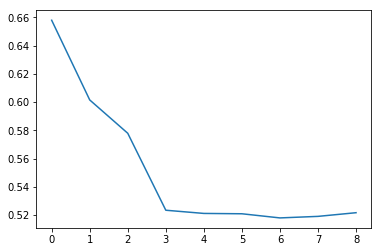

In [22]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

As you can see, the network very quickly learns to capture the first dependency (but not the second), and converges to the expected cross-entropy loss of 0.52.



## TensorFlow API (`static_rnn`)
Translating our model to Tensorflow’s API is easy. We simply replace these two sections:
```
with tf.variable_scope('rnn_cell'):
    ...
def rnn_cell(rnn_input, state):
    ...
```
```
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

```

with
```
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)
```

In [36]:
tf.reset_default_graph()

In [37]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [28]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

In [29]:
training_losses = train_network(1,num_steps)


EPOCH 0
Average loss at step 100 for last 250 steps: 0.6223545253276825
Average loss at step 200 for last 250 steps: 0.5226381602883339
Average loss at step 300 for last 250 steps: 0.5195956349372863
Average loss at step 400 for last 250 steps: 0.5214451411366463
Average loss at step 500 for last 250 steps: 0.5186074489355087
Average loss at step 600 for last 250 steps: 0.5219508638978004
Average loss at step 700 for last 250 steps: 0.5199247208237648
Average loss at step 800 for last 250 steps: 0.5210795599222183
Average loss at step 900 for last 250 steps: 0.5230103918910026


There are two major downsides. 
* First, a graph composed in this way has to be **fixed length**, which means you’ll **have to rebuild the graph for different length signals, or pad them out with zeros**. Neither solution is great.

* Second, **large graphs take much longer to build and consume much more RAM**. Depending on the constraints of your computing environment, this could be prohibitive.

The `tf.dynamic_rnn` function will transform your RNNCell into a dynamically generated graph that passes the state, whatever that may be, from one time step to the next, and keeps track of the outputs. 

## TensorFlow API (`dynamic_rnn`)

Above, we added every node for every timestep to the graph before execution. This is called “static” construction. We could also let Tensorflow dynamically create the graph at execution time, which can be more efficient. To do this, instead of using a list of tensors (of length `num_steps` and shape `[batch_size, features]`), we keep everything in a single 3-dimnesional tensor of shape `[batch_size, num_steps, features]`, and use Tensorflow’s `dynamic_rnn` function. This is shown below.

In [125]:
tf.reset_default_graph()

In [126]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

"""
Predictions, loss, training step
"""

with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [33]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

In [34]:
training_losses = train_network(1,num_steps)


EPOCH 0
Average loss at step 100 for last 250 steps: 0.6449662911891937
Average loss at step 200 for last 250 steps: 0.5688766324520111
Average loss at step 300 for last 250 steps: 0.5277942746877671
Average loss at step 400 for last 250 steps: 0.5149962466955185
Average loss at step 500 for last 250 steps: 0.5182683664560318
Average loss at step 600 for last 250 steps: 0.5161534306406975
Average loss at step 700 for last 250 steps: 0.5155144155025482
Average loss at step 800 for last 250 steps: 0.514730055630207
Average loss at step 900 for last 250 steps: 0.5167294222116471


## Approximating `dynamic_rnn` with `tf.scan`
Scan is a higher-order function that takes a function $(f:(x_t,y_{t−1})↦y_t)$, a sequence ($[x_0,x_1…x_n]$) and an initial value ($y−1$) and returns a sequence ($[y_0,y_1…y_n]$) according to the rule: $y_t=f(x_t,y_{t−1}$). In Tensorflow, scan treats the first dimension of a Tensor as the sequence. Thus, if fed a Tensor of shape $[n, m, o]$ as the sequence, scan would unpack it into a sequence of n-tensors, each with shape $[m, o]$. 

In [111]:
tf.reset_default_graph()

In [112]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
#init_state = tf.zeros([batch_size, state_size])

"""
Inputs
"""

rnn_inputs = tf.one_hot(x, num_classes) # shape=(200, 5, 2)

"""
RNN
"""

cell = tf.contrib.rnn.BasicRNNCell(state_size)
"""
tf.scan
    Args:
        fn: two arguments (1st same structure as initializer, 2nd the same as elems)
        elems: sequence of tensors unpacked along their first dimension
        initializer: initial value for the accumulator
"""
"""
cell.__call__
    Args:
        inputs: 2-D tensor with shape [batch_size, input_size]
        state: 2-D Tensor with shape [batch_size, self.state_size].
    Returns:
        Output: A 2-D tensor with shape [batch_size, self.output_size].
        New state: Either a single 2-D tensor, or a tuple of tensors matching the arity and shapes of state.
"""
init_state = cell.zero_state(batch_size, tf.float32)
rnn_outputs, final_states = \
    tf.scan(lambda accum, elem: cell(elem, accum[1]), # call(inputs, state)
            tf.transpose(rnn_inputs, [1,0,2]), # shape=(5, 200, 2)
            initializer=(tf.zeros([batch_size, state_size]), init_state))
# (shape=(5, 200, 4), shape=(5, 200, 4))

Another thing to note is that scan produces rnn_outputs with shape `[num_steps, batch_size, state_size]`, whereas the dynamic_rnn produces rnn_outputs with shape `[batch_size, num_steps, state_size] `(the first two dimensions are switched). Dynamic_rnn has the flexibility to switch this behavior, using the `time_major` argument. `Tf.scan` does not have this flexibility, which is why we transpose `rnn_inputs` and `y` in the code below.

In [113]:
rnn_outputs

<tf.Tensor 'scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(5, 200, 4) dtype=float32>

In [114]:
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

rnn_outputs = tf.transpose(rnn_outputs, [1, 0, 2]) # shape=(200, 5, 4) 

In [128]:
logits = tf.reshape(
            tf.matmul(tf.reshape(rnn_outputs, [-1, state_size]), W) + b,
            [batch_size, num_steps, num_classes])
predictions = tf.nn.softmax(logits)

In [131]:
total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

Using scan was only marginally slower than using `dynamic_rnn`, and gives us the flexibility and understanding to tweak the code if we ever need to (e.g., if for some reason we wanted to create a skip connection from the state at timestep `t-2` to timestep `t`, it would be easy to do with scan).

### Upgrading the RNN cell

We can seamlessly swap out the BasicRNNCell we were using for a Multi-layered LSTM cell. This was possible because the RNN cells conform to a general structure: every RNN cell is a function of the current input, $X_t$, and the prior state, $S_{t−1}$, that outputs a current state, $S_t$, and a current output, $Y_t$.

In [137]:
cell = tf.nn.rnn_cell.BasicRNNCell(state_size) # RNN
cell = tf.nn.rnn_cell.LSTMCell(state_size) # LSTM
cell = tf.nn.rnn_cell.GRUCell(state_size) # GRU

num_layers = 5
cell = tf.nn.rnn_cell.MultiRNNCell( # Stacked LSTM
    [tf.nn.rnn_cell.LSTMCell(state_size)] * num_layers)